In [1]:
import sys, json, os
from jupyter_client.kernelspec import KernelSpecManager
print(KernelSpecManager().get_all_specs().keys())  # should include 'open-coverage-py'

dict_keys(['python312', 'open-coverage-py', 'python3'])


In [ ]:
# Install shap if not available
import sys
!{sys.executable} -m pip install shap

# What does this model do?

1. Predicts utilization counts for each category (e.g., PCP visits, Rx fills, inpatient stays).

2. Multiplies predicted counts by unit costs from insurance data to estimate total allowed cost.
This is then run through a benefit calculator to estimate patient out-of-pocket (OOP) costs.

Model is trained on MEPS data: https://meps.ahrq.gov/mepsweb/data_stats/download_data_files.jsp

# Imports

In [13]:
import pandas as pd
import polars as pl # using polars library for large .xlsx files
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import FunctionTransformer
import shap
import joblib
import os

# Load MEPS Data

ChatGPT: Use consolidated from year t and counts from year t+1 if you're predicting future utilization (prospective), which is better for real-world use.

We are using consolidated from 2022 and counts from 2023.

## Consolidated Data

**Skip if h243.xlsx has already been converted to .csv and .parquet.**

In [ ]:
# Define schema for problematic columns
schema_overrides = {
    'HRWG53X': pl.Float64,  # Use float instead of int for decimal values
    # Add other problematic columns as needed
}

df = pl.read_excel(
    "/Users/orenj/Desktop/Projects/open-coverage/python-models/data/h243.xlsx",
    schema_overrides=schema_overrides
)

df.head()

Convert to faster data formats for later use

In [ ]:
df.write_csv("/Users/orenj/Desktop/Projects/open-coverage/python-models/data/h243.csv")  # Much faster for future loads
df.write_parquet("/Users/orenj/Desktop/Projects/open-coverage/python-models/data/h243.parquet")  # Even faster, compressed

Load MEPS Consolidated File (person-level features + target)

In [2]:
df_cons = pd.read_parquet("/Users/orenj/Desktop/open-coverage/python-models/data/MEPS/2022-consolidated/h243.parquet")

df_cons.head()

,DUID,PID,DUPERSID,PANEL,DATAYEAR,FAMID31,FAMID42,FAMID53,FAMID22,FAMIDYR,...,RXOSR22,RXPTR22,RXOTH22,PERWT22F,FAMWT22F,FAMWT22C,SAQWT22F,DIABW22F,VARSTR,VARPSU
0,2460002,101,2460002101,24,2022,A,A,A,A,A,...,0,0,0,5728.309495,5232.211986,5232.211986,3994.687140,6034.636755,2082,1
1,2460006,101,2460006101,24,2022,A,A,A,A,A,...,0,0,0,15648.881461,16017.881691,16017.881691,0.000000,0.000000,2001,4
2,2460006,102,2460006102,24,2022,A,A,A,A,A,...,0,0,0,14123.720178,16017.881691,12580.731740,0.000000,0.000000,2001,4
3,2460010,101,2460010101,24,2022,A,A,A,A,A,...,0,5288,299,16982.054917,21905.758877,21905.758877,0.000000,0.000000,2038,3
4,2460018,101,2460018101,24,2022,A,A,A,A,A,...,0,10,0,10682.619947,11344.291012,11344.291012,17152.439412,0.000000,2041,1


## Aggregate Event Files

Load data files for **Counts per Person**

In [3]:
event_files = {
    "pcp_visits": "/Users/orenj/Desktop/open-coverage/python-models/data/MEPS/2023-counts/h248g.xlsx",            # Office-based visits
    "outpatient_visits": "/Users/orenj/Desktop/open-coverage/python-models/data/MEPS/2023-counts/h248f.xlsx",     # Outpatient visits
    "er_visits": "/Users/orenj/Desktop/open-coverage/python-models/data/MEPS/2023-counts/h248e.xlsx",             # Emergency Room visits
    "inpatient_admits": "/Users/orenj/Desktop/open-coverage/python-models/data/MEPS/2023-counts/h248d.xlsx",      # Inpatient stays
    "home_health_visits": "/Users/orenj/Desktop/open-coverage/python-models/data/MEPS/2023-counts/h248h.xlsx",    # Home health visits
    "rx_fills": "/Users/orenj/Desktop/open-coverage/python-models/data/MEPS/2023-counts/h248a.xlsx",              # Prescription fills
    "dental_visits": "/Users/orenj/Desktop/open-coverage/python-models/data/MEPS/2023-counts/h248b.xlsx",         # Dental visits
    "equipment_purchases": "/Users/orenj/Desktop/open-coverage/python-models/data/MEPS/2023-counts/h248c.xlsx"    # Medical equipment/supplies
}

# Count records per DUPERSID for each event type
counts_dict = {}
for feat_name, filepath in event_files.items():
    # Use pandas with usecols parameter (which works correctly)
    df_evt = pd.read_excel(filepath, usecols=["DUPERSID"])
    
    # Count occurrences per DUPERSID
    counts = df_evt.groupby("DUPERSID").size().rename(feat_name)
    counts_dict[feat_name] = counts

# Merge all counts into a single DataFrame
counts_df = (
    pd.concat(counts_dict.values(), axis=1)
      .fillna(0)
      .reset_index()
)

## Merge consolidated with counts

Doing a left join on DUPERSID so everyone is included in the dataset. Also need to predict those with zero events.

DUPERSID: AHRQ‑generated person identifier (derived from dwelling/unit and person IDs). It uniquely identifies a respondent within a year, and from 2018 onward it’s constructed to be unique across panels/year.

In [4]:
df = (
    df_cons
      .merge(counts_df, on="DUPERSID", how="left")
      .fillna(0)
)
df.head()

,DUID,PID,DUPERSID,PANEL,DATAYEAR,FAMID31,FAMID42,FAMID53,FAMID22,FAMIDYR,...,VARSTR,VARPSU,pcp_visits,outpatient_visits,er_visits,inpatient_admits,home_health_visits,rx_fills,dental_visits,equipment_purchases
0,2460002,101,2460002101,24,2022,A,A,A,A,A,...,2082,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2460006,101,2460006101,24,2022,A,A,A,A,A,...,2001,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2460006,102,2460006102,24,2022,A,A,A,A,A,...,2001,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2460010,101,2460010101,24,2022,A,A,A,A,A,...,2038,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2460018,101,2460018101,24,2022,A,A,A,A,A,...,2041,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.shape

(22431, 1428)

# Select Features and Target Variables

Introduced 30 more features in v2. Feature descriptions are available in table below.

| **Category**               | **Feature**                 | **Variable Name**                  | **Description**                                                    |
| -------------------------- | --------------------------- | ---------------------------------- | ------------------------------------------------------------------ |
| **Identifiers**            | Person ID                   | `person_id`                        | Unique person identifier (for merges)                              |
| **Demographics**           | Age                         | `age_years_2022`                   | Age as of 12/31/2022 (imputed)                                     |
|                            | Sex                         | `gender`                           | Survey-reported gender (1 = Male, 2 = Female)                      |
|                            | Race/Ethnicity              | `race_ethnicity`                   | Detailed race and ethnicity categories                             |
|                            | Hispanic Category           | `hispanic_origin_category`         | Categorical breakdown of Hispanic origin                           |
|                            | Region                      | `census_region`                    | Census region (Northeast, Midwest, South, West)                    |
|                            | Metro Status                | `metro_status`                     | 1 = MSA • 2 = non-MSA • 3 = unknown                                |
| **Socioeconomic**          | Education (years)           | `education_years`                  | Years of schooling when first entered MEPS                         |
|                            | Highest Degree              | `highest_degree_achieved`          | Highest educational degree achieved                                |
|                            | Family Income               | `family_income_2022`               | Total family income in 2022                                        |
|                            | Poverty Level (%)           | `poverty_level_pct`                | Family income as % of federal poverty line                         |
|                            | Poverty Category            | `poverty_category`                 | Poverty status category (<100%, 100–199%, ≥200%)                   |
|                            | Employment Status           | `employment_status`                | Employed full-/part-time vs. unemployed/inactive                   |
|                            | Hours Worked/Week           | `hours_worked_per_week`            | Usual hours worked/week                                            |
|                            | Industry Category           | `occupation_industry_category`     | Broad industry category of current/most recent job                 |
|                            | Family Size                 | `family_size`                      | Number of people in the family unit                                |
|                            | Marital Status              | `marital_status`                   | Married vs. single/divorced/widowed                                |
|                            | Spouse Present              | `spouse_in_household`              | Indicates if spouse resides in same household                      |
| **Access & Utilization**   | Insurance Status            | `insurance_coverage_type`          | 1 = Any private • 2 = Public only • 3 = Uninsured                  |
|                            | Usual Source of Care        | `has_usual_source_of_care`         | Has a usual source of medical care                                 |
|                            | Location of Usual Care      | `usual_care_location_type`         | Type/location of usual source (clinic, doctor’s office, etc.)      |
|                            | Could Not Afford Care       | `delayed_care_due_to_cost`         | Delayed/forgone medical care due to cost                           |
|                            | Delayed Medicine (Cost)     | `delayed_prescription_due_to_cost` | Delayed getting prescription medicine because of cost              |
|                            | Food Stamp Receipt          | `received_snap`                    | Received SNAP benefits                                             |
|                            | Food Stamp Value            | `snap_benefit_value_2022`          | Total value of SNAP benefits received in 2022                      |
| **Behaviors & Lifestyle**  | BMI                         | `bmi`                              | Body Mass Index (>17) from Round 4/5                               |
|                            | Smoking Frequency           | `smoking_frequency`                | “How often use tobacco” in past 12 months                          |
|                            | Alcohol Consumption         | `alcohol_consumption_frequency`    | Alcohol drinking in past 12 months                                 |
|                            | Exercise                    | `exercise_days_per_week`           | Average days/week of moderate/vigorous activity                    |
|                            | English Proficiency         | `english_proficiency`              | Self-rated English speaking ability                                |
|                            | Nativity                    | `us_born_flag`                     | Born in the United States?                                         |
|                            | Years in U.S.               | `years_in_us`                      | Years lived in the United States                                   |
| **Functional & Cognitive** | Difficulty Lifting          | `difficulty_lifting_carrying`      | Serious difficulty lifting or carrying                             |
|                            | Difficulty Walking/Stairs   | `difficulty_walking_stairs`        | Serious difficulty walking or climbing stairs                      |
|                            | Any Activity Limitation     | `any_activity_limitation`          | Any limitation in usual activities due to health                   |
|                            | Cognitive Limitation        | `cognitive_limitation`             | Serious difficulty concentrating, remembering, or making decisions |
|                            | Psychological Distress (K6) | `k6_distress_score`                | Kessler 6-item psychological distress score (0–24)                 |
|                            | Feelings of Hopelessness    | `hopelessness_frequency_30d`       | Frequency of feeling hopeless in past 30 days                      |
|                            | Feelings of Sadness         | `sadness_frequency_30d`            | Frequency of feeling sad or depressed in past 30 days              |
| **Health Status**          | Chronic Condition Count     | `chronic_condition_count`          | Number of chronic conditions                                       |
| **Outcome**                | Total Expenditures (target) | `total_expenditures_2022`          | Sum of all payments in 2022                                        |


### Rename input variables

In [6]:
# Rename MEPS columns to descriptive names
df.rename(columns={
    "DUPERSID": "person_id",
    "AGE22X": "age_years_2022",
    "ADSEX42": "gender",
    "RACETHX": "race_ethnicity",
    "HISPNCAT": "hispanic_origin_category",
    "REGION22": "census_region",
    "MSA22": "metro_status",
    "EDUCYR": "education_years",
    "HIDEG": "highest_degree_achieved",
    "FAMINC22": "family_income_2022",
    "POVLEV22": "poverty_level_pct",
    "POVCAT22": "poverty_category",
    "EMPST42": "employment_status",
    "HOUR42": "hours_worked_per_week",
    "OCCCAT42": "occupation_industry_category",
    "FAMSZE22": "family_size",
    "MARRY22X": "marital_status",
    "SPOUIN22": "spouse_in_household",
    "INSCOV22": "insurance_coverage_type",
    "HAVEUS42": "has_usual_source_of_care",
    "LOCATN42": "usual_care_location_type",
    "AFRDCA42": "delayed_care_due_to_cost",
    "DLAYPM42": "delayed_prescription_due_to_cost",
    "FOODST22": "received_snap",
    "FOODVL22": "snap_benefit_value_2022",
    "ADBMI42": "bmi",
    "ADOSTP42": "smoking_frequency",
    "ADASKALC42": "alcohol_consumption_frequency",
    "ADDAYEXER42": "exercise_days_per_week",
    "HWELLSPK": "english_proficiency",
    "BORNUSA": "us_born_flag",
    "YRSINUS": "years_in_us",
    "LFTDIF31": "difficulty_lifting_carrying",
    "DFWLKC42": "difficulty_walking_stairs",
    "ACTLIM31": "any_activity_limitation",
    "COGLIM31": "cognitive_limitation",
    "K6SUM42": "k6_distress_score",
    "ADHOPE42": "hopelessness_frequency_30d",
    "ADSAD42": "sadness_frequency_30d",
    "TOTCHRON": "chronic_condition_count",
    "TOTEXP22": "total_expenditures_2022"
}, inplace=True)

### Combine datasets

In [7]:
feature_cols = [
    "age_years_2022",
    "gender",
    "race_ethnicity",
    "hispanic_origin_category",
    "census_region",
    "education_years",
    "highest_degree_achieved",
    "family_income_2022",
    "poverty_level_pct",
    "poverty_category",
    "employment_status",
    "hours_worked_per_week",
    "occupation_industry_category",
    "family_size",
    "marital_status",
    "spouse_in_household",
    "insurance_coverage_type",
    "has_usual_source_of_care",
    "usual_care_location_type",
    "delayed_care_due_to_cost",
    "delayed_prescription_due_to_cost",
    "received_snap",
    "snap_benefit_value_2022",
    "bmi",
    "smoking_frequency",
    "alcohol_consumption_frequency",
    "exercise_days_per_week",
    "english_proficiency",
    "us_born_flag",
    "years_in_us",
    "difficulty_lifting_carrying",
    "difficulty_walking_stairs",
    "any_activity_limitation",
    "cognitive_limitation",
    "k6_distress_score",
    "hopelessness_frequency_30d",
    "sadness_frequency_30d",
    # "metro_status",            # couldn't find but doesn't matter for now
    # "chronic_condition_count"  # MAKE SURE TO UNCOMMENT WHEN USING
]

count_targets = [
    "pcp_visits", "outpatient_visits", "er_visits",
    "inpatient_admits", "home_health_visits",
    "rx_fills", "dental_visits", "equipment_purchases"
]

X = df[feature_cols]
y = df[count_targets].clip(lower=0)

## Null Value Analysis

In [ ]:
# df = the raw feature frame BEFORE your existing Pipeline
n_rows = len(df)

missing_summary = (
    df.isna()
      .agg(['sum', 'mean'])            # absolute count + proportion
      .T
      .rename(columns={'sum':'n_null', 'mean':'null_rate'})
      .assign(datatype=df.dtypes)      # keep data type in view
      .sort_values('null_rate', ascending=False)
)

pd.set_option('display.max_rows', None)
display(missing_summary)
# …then later, if you want to go back to default:
pd.reset_option('display.max_rows')

**Conclusion: there are no null values in MEPS data.**

# Preprocess Data

## Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Preprocessor for Categorical Features

The MEPS dataset has reserved negative codes to indicate different reasons for null values instead of just leaving the observation null. For v2 I will just convert these negative codes to null. This can be addressed in a later model version. Ex. -7 = respondant refused to answer the question, -8 = respondant did not know the information

In [10]:
# All negative “not-real” answers in the 2022 Consolidated PUF
MEPS_2022_RESERVED = {
    -1:  "inapplicable",
    -2:  "determined_prev_round",
    -7:  "refused",
    -8:  "dont_know_or_not_ascertained",
    -10: "hourly_wage_topcode",        # wage-only variables
    -13: "initial_wage_imputed",       # wage-only variables
    -15: "cannot_be_computed"
}
NEG_CODES = list(MEPS_2022_RESERVED.keys())

def neg_to_nan(X: pd.DataFrame) -> pd.DataFrame:
    """Replace MEPS reserved negative codes with NaN."""
    return X.replace(NEG_CODES, np.nan)

nanifier = FunctionTransformer(neg_to_nan, feature_names_out="one-to-one") # convert codes to NaN

Process categories using one hot encoding.

In [11]:
# 1. List your categorical columns
categorical_cols = [
    # Demographics
    "gender",
    "race_ethnicity",
    "hispanic_origin_category",
    "census_region",
    #"metro_status", 
    # Socioeconomic (categorical)
    "highest_degree_achieved",
    "poverty_category",
    "employment_status",
    "occupation_industry_category",
    "marital_status",
    "spouse_in_household",
    # Access & Utilization
    "insurance_coverage_type",
    "has_usual_source_of_care",
    "usual_care_location_type",
    "delayed_care_due_to_cost",
    "delayed_prescription_due_to_cost",
    "received_snap",
    # Behaviors & Lifestyle
    "smoking_frequency",
    "alcohol_consumption_frequency",
    "english_proficiency",
    "us_born_flag",
    # Functional & Cognitive
    "difficulty_lifting_carrying",
    "difficulty_walking_stairs",
    "any_activity_limitation",
    "k6_distress_score",
    # (you can add more here if you treat them as categorical)
]

# 2. Build a little pipeline just for categoricals
categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(      # not imputing NaNs because HistGradientBoostingRegressor natively handles them; change if algorithm changes
        handle_unknown="ignore",   # don't crash if new categories appear in test
        sparse_output=False,             # return a dense array (needed for shap, etc.)
        drop="if_binary"          # drop one level for binary vars to avoid collinearity
    ))
])

# 3. Hook it into a ColumnTransformer (you’d add your numeric step(s) too)
preprocessor = ColumnTransformer([
    ("cat", categorical_transformer, categorical_cols),
    # ("num", numeric_transformer, numeric_cols),  <-- your existing numeric step here
],
    remainder="passthrough"   # if you have any extras you’re just passing through
)

# Train/Fit the Model

## Fit one Poisson GBM per count target

There are **8 count targets** so we are building a model for each.

The HistGradientBoostingRegressor has native support for missing values (NaNs). If you decide to use a different estimator, check to see if you need to imput values.

In [12]:
models = {}
preds = pd.DataFrame(index=X_test.index)

for target in count_targets:
    pipe = Pipeline([
        ("nanifier", nanifier), # convert negative codes to NaN
        ("preproc", preprocessor), # encoding/scaling
        ("model", HistGradientBoostingRegressor(
            loss="poisson",
            max_iter=200,
            learning_rate=0.1,
            random_state=42
        ))
    ])
    pipe.fit(X_train, y_train[target])
    models[target] = pipe
    preds[target] = pipe.predict(X_test).clip(min=0)

# Persist to disk so you can reload later in the same notebook
for target, pipe in models.items():
    joblib.dump(pipe, f"/Users/orenj/Desktop/open-coverage/python-models/models/v2-pkl/model_{target}.pkl")

Reload your models

In [14]:
# Directory where the model files are saved
model_dir = "/Users/orenj/Desktop/open-coverage/python-models/models/v2-pkl"

# Dictionary to store reloaded models
models = {}

# DataFrame to store predictions
preds = pd.DataFrame(index=X_test.index)

# Reload models and make predictions
for target in count_targets:
    model_path = os.path.join(model_dir, f"model_{target}.pkl")
    
    # Load the model from the pickle file
    pipe = joblib.load(model_path)
    models[target] = pipe
    
    # Make predictions (clip to non-negative values, just like before)
    preds[target] = pipe.predict(X_test).clip(min=0)

print("Models reloaded and predictions generated.")

Models reloaded and predictions generated.


Ensure negative MEPS values have been mapped to NaNs. *See Preprocessor for Categorical Features section.*

In [13]:
# Get the fitted OneHotEncoder
ohe = pipe.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']

# Show the list of categories for each categorical column
for col, cats in zip(categorical_cols, ohe.categories_):
    print(f"{col}: {list(cats)}")

gender: [1.0, 2.0, nan]
race_ethnicity: [1, 2, 3, 4, 5]
hispanic_origin_category: [1, 2, 3, 4, 5, 6, 8, 9]
census_region: [1.0, 2.0, 3.0, 4.0, nan]
highest_degree_achieved: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]
poverty_category: [1, 2, 3, 4, 5]
employment_status: [1.0, 2.0, 3.0, 4.0, nan]
occupation_industry_category: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, nan]
marital_status: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]
spouse_in_household: [1.0, 2.0, 3.0, nan]
insurance_coverage_type: [1, 2, 3]
has_usual_source_of_care: [1.0, 2.0, nan]
usual_care_location_type: [1.0, 2.0, 3.0, nan]
delayed_care_due_to_cost: [1.0, 2.0, nan]
delayed_prescription_due_to_cost: [1.0, 2.0, nan]
received_snap: [1.0, 2.0, nan]
smoking_frequency: [1.0, 2.0, nan]
alcohol_consumption_frequency: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]
english_proficiency: [1.0, 2.0, 3.0, 4.0, 5.0, nan]
us_born_flag: [1.0, 2.0, nan]
difficulty_lifting_carrying: [1.0, 2.0, 3.0, 4.0, nan]
difficulty_walking_stairs: [1.

# Model Evaluation

## Evaluate Each Count Model

Count Models Evaluation (per-category):
                          MAE       RMSE
feature                                 
pcp_visits           3.865654   8.770475
outpatient_visits    0.645998   3.608962
er_visits            0.144003   0.420944
inpatient_admits     0.069698   0.235955
home_health_visits   0.270050   1.995248
rx_fills             5.711369  12.868715
dental_visits        0.585439   1.101677
equipment_purchases  0.339847   0.611027


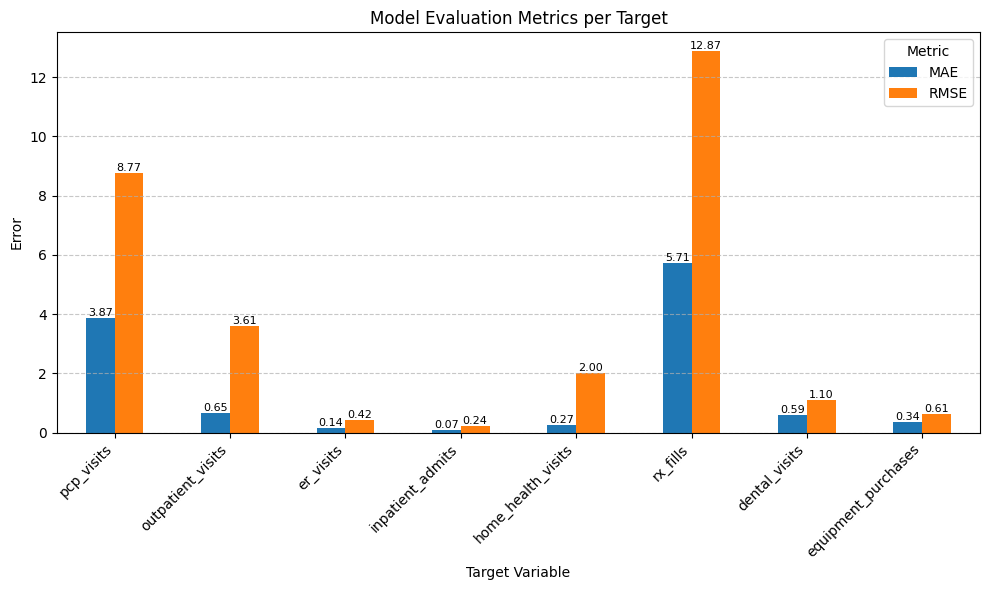

In [ ]:
metrics = []
for target in count_targets:
    mae = mean_absolute_error(y_test[target], preds[target])
    rmse = root_mean_squared_error(y_test[target], preds[target])
    metrics.append({
        "feature": target,
        "MAE": mae,
        "RMSE": rmse
    })

metrics_df = pd.DataFrame(metrics).set_index("feature")
print("Count Models Evaluation (per-category):")
print(metrics_df)

# ---- Bar chart ----
ax = metrics_df.plot(kind="bar", figsize=(10, 6))
plt.title("Model Evaluation Metrics per Target")
plt.ylabel("Error")
plt.xlabel("Target Variable")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Metric")

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

## Predict counts for a synthetic user

For testing missing data use 'np.nan' instead of the value.

In [ ]:
# Define realistic synthetic data for one individual
synthetic_user = {
    # Identifiers
    "person_id": 99999999,

    # Demographics
    "age_years_2022": 57,
    "gender": np.nan,                      # Female
    "race_ethnicity": 3,             # Black/African American
    "hispanic_origin_category": -1,  # Not Hispanic
    "census_region": 3,              # South
    # "metro_status": 1,             # In MSA

    # Socioeconomic
    "education_years": 12,
    "highest_degree_achieved": 3,    # High school graduate
    "family_income_2022": 32000,
    "poverty_level_pct": 140,        # 140% of FPL
    "poverty_category": 2,           # 100–199%
    "employment_status": 2,          # Unemployed
    "hours_worked_per_week": 0,
    "occupation_industry_category": -1,  # Not applicable / unemployed
    "family_size": 3,
    "marital_status": 2,             # Widowed
    "spouse_in_household": 2,        # No spouse in household

    # Access & Utilization
    "insurance_coverage_type": 2,          # Public only (e.g., Medicaid)
    "has_usual_source_of_care": 1,         # Has usual source of care
    "usual_care_location_type": 2,         # Clinic/health center
    "delayed_care_due_to_cost": 1,         # Could not afford care
    "delayed_prescription_due_to_cost": 1, # Delayed meds due to cost
    "received_snap": 1,                    # Received food stamps
    "snap_benefit_value_2022": 1500,

    # Behaviors & Lifestyle
    "bmi": 34.2,                         # Obese
    "smoking_frequency": 2,             # Some days
    "alcohol_consumption_frequency": 3, # <4 times/week
    "exercise_days_per_week": 1,        # 1 day/week
    "english_proficiency": 4,           # Very well
    "us_born_flag": 1,                  # Born in US
    "years_in_us": -1,                  # N/A (born in US)

    # Functional & Cognitive
    "difficulty_lifting_carrying": 1,       # Yes, difficulty lifting
    "difficulty_walking_stairs": 2,         # No difficulty walking
    "any_activity_limitation": 1,           # Yes, limited activities
    "cognitive_limitation": 2,              # No cognitive limitations
    "k6_distress_score": 9,                 # Moderate psychological distress
    "hopelessness_frequency_30d": 3,        # Some of the time
    "sadness_frequency_30d": 3,             # Some of the time

    # Health Status
    # "chronic_condition_count": 4,        # Has multiple chronic conditions

    # Outcome (for training)
    "total_expenditures_2022": 18934.65     # Total expenditures in 2022 (USD)
}

# Create DataFrame with the synthetic individual
synthetic_df = pd.DataFrame([synthetic_user])

# Make predictions using the trained models
predictions = {}
for target in count_targets:
    # Use the trained model to predict
    pred_value = models[target].predict(synthetic_df)[0]
    predictions[target] = max(0, round(pred_value))  # Ensure non-negative integers

# Create predictions DataFrame
predictions_df = pd.DataFrame([predictions])

print("Predicted Healthcare Utilization Counts:")
display(predictions_df)

# Feature Analysis

## SHAP Values for Feature Importance

### SHAP v2

Computation in SHAP v1 took an hour to compute - this is uncessary. I am using a technique from this [paper](https://parthenonfrontiers.com/index.php/ejeai/article/view/49) to reduce the computation time. It uses Slovin's sample method to reduce the computational load.

In [15]:
def slovins_sample(df, error=0.02, random_state=42):
    """Return a Slovin-sized subsample of df."""
    N = len(df)
    n = int(N / (1 + N * error**2))
    return df.sample(n=n, random_state=random_state)

Reload a model & build SHAP background

In [18]:
TARGET = count_targets[0]            # pick a target to explain (0-7)
pipe   = joblib.load(f"/Users/orenj/Desktop/open-coverage/python-models/models/v2-pkl/model_{TARGET}.pkl")

# Build a reduced background set once
X_background = slovins_sample(X_train, error=0.02)
Xb_trans     = pipe.named_steps["preproc"].transform(X_background)

# TreeExplainer on the fitted tree model
explainer = shap.TreeExplainer(
    pipe.named_steps["model"],       # the trained HGBRegressor
    data=Xb_trans,                    # background in transformed space
    feature_perturbation="interventional" # This forces SHAP to exactly satisfy additivity (at the cost of some speed):
)

# Pre‐transform test set
Xt_trans = pipe.named_steps["preproc"].transform(X_test)

# Compute SHAP‐values on the transformed data, disabling a check
shap_vals = explainer.shap_values(
    Xt_trans,
    check_additivity=False
)

# Plot
feat_names = pipe.named_steps["preproc"].get_feature_names_out()

Found unknown categories in columns [0, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros


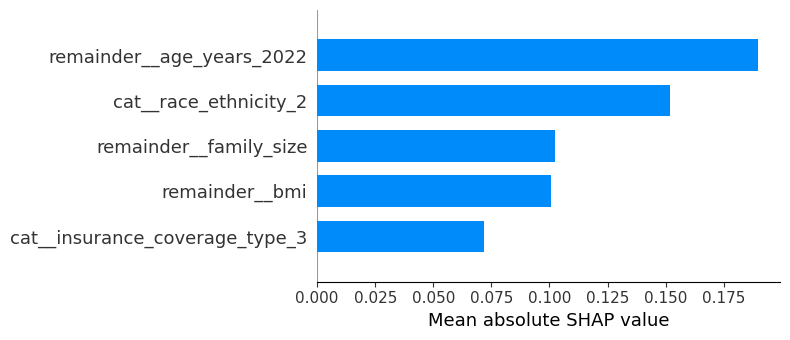

In [22]:
shap.summary_plot(
    shap_vals,           # your array of shap values
    Xt_trans,            # the corresponding transformed data
    feature_names=feat_names,
    plot_type="bar",      # <-- this makes it a bar chart
    max_display=5,        # show top 5 features
    show=False
)
# Get current axes and change x-axis label
plt.xlabel("Mean absolute SHAP value")
plt.show()

Print a SHAP bar graph for all models at once

Found unknown categories in columns [0, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23

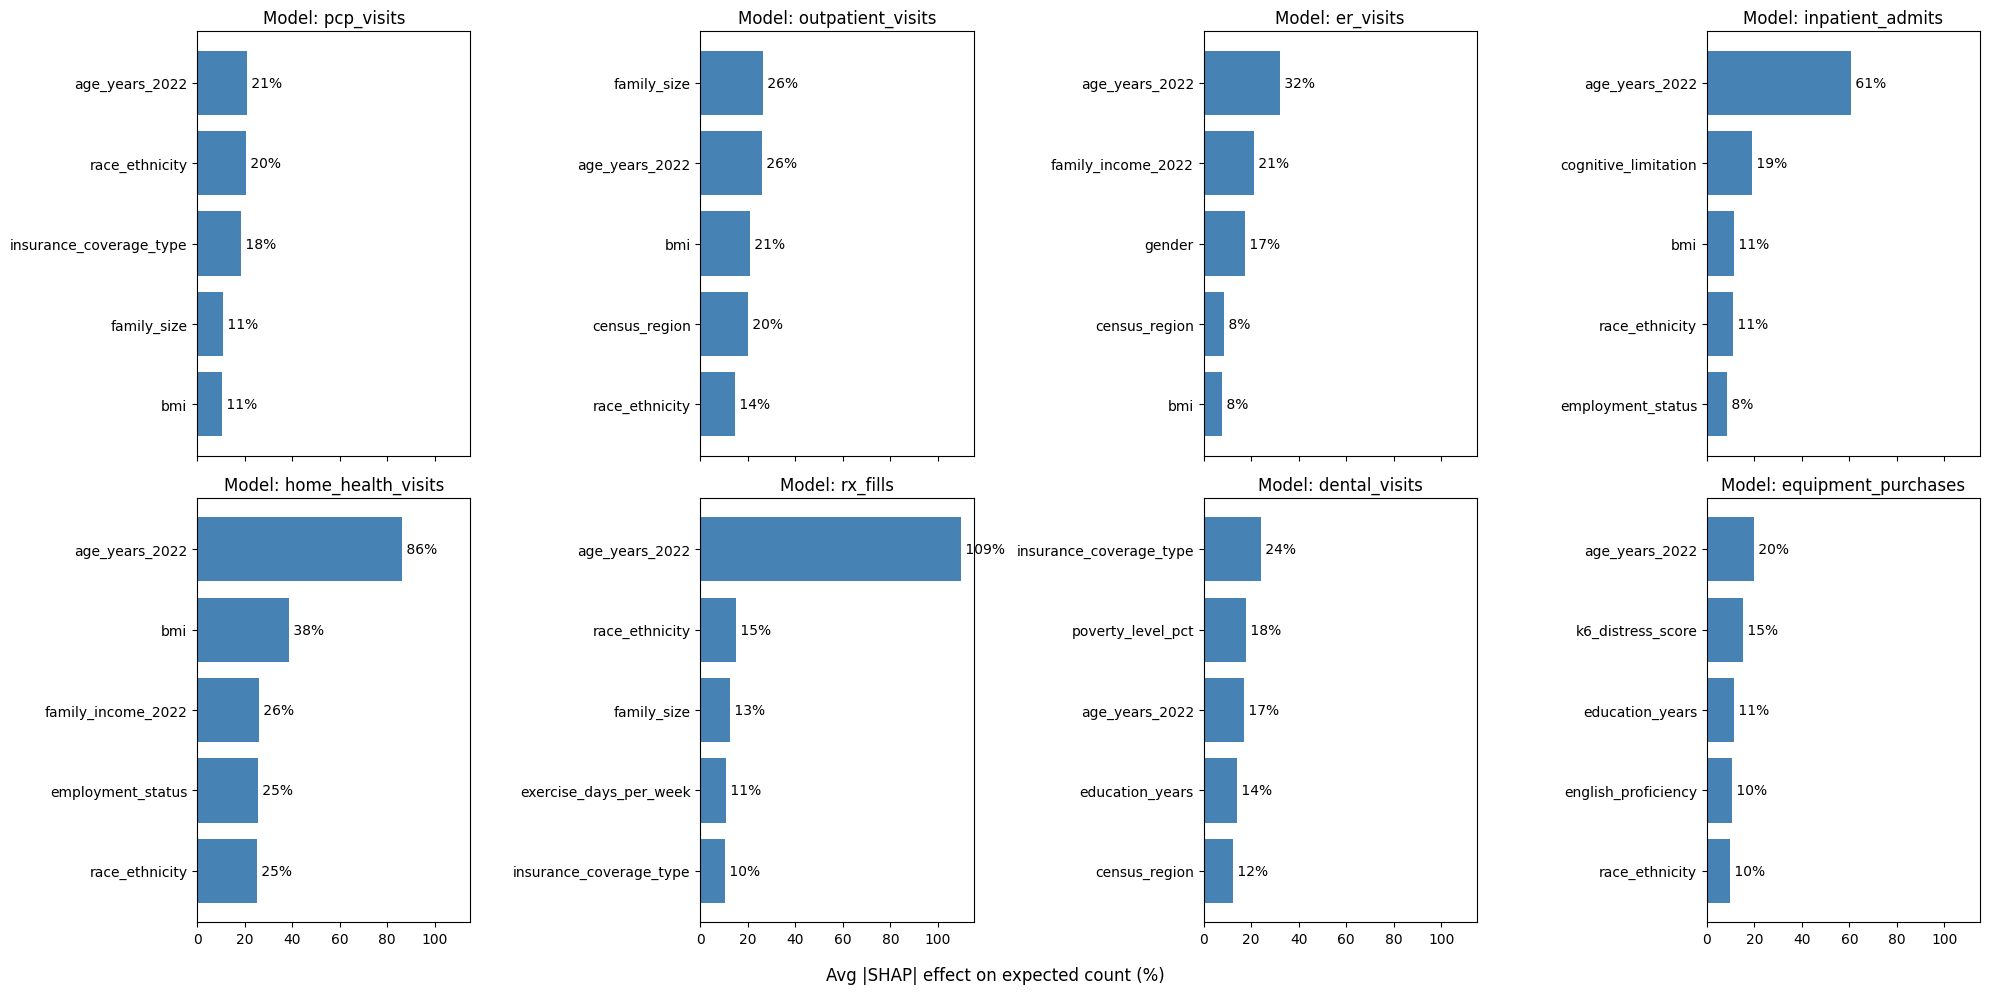

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib

# -------------------- CONFIG --------------------
TOP_K = 5                 # top features per model
SCALE = "pct"             # "pct" for % effect (recommended), "log" for raw log-units
BAR_COLOR = "steelblue"   # or a palette/list

# ----------------- HELPER FUNCTIONS -------------
def parent_feature_name(transformed_name: str) -> str:
    """
    Map a transformed feature name back to its parent feature.
    Works with ColumnTransformer-style names like:
      - 'cat__race_ethnicity_2'  -> 'race_ethnicity'
      - 'remainder__age_years_2022' -> 'age_years_2022'
    If your prefixes differ (e.g., 'num__', 'ohe__'), adjust below.
    """
    if "__" in transformed_name:
        prefix, rest = transformed_name.split("__", 1)  # e.g., ('cat', 'race_ethnicity_2')
        if prefix == "cat":
            # drop the trailing _<category> for OHE columns
            parent = rest.rsplit("_", 1)[0]
            return parent
        else:
            # numeric/remainder/etc.: already a single column
            return rest
    return transformed_name

def pretty(name: str) -> str:
    """What to print on the y-axis."""
    return name

def scale_vals(mean_abs_log: np.ndarray) -> np.ndarray:
    """
    Convert mean(|φ|) from log scale to display scale.
    - 'pct' -> approx % effect on expected count: (exp(mean|φ|) - 1)*100
    - 'log' -> raw log-units
    """
    if SCALE == "pct":
        return np.expm1(mean_abs_log) * 100.0
    return mean_abs_log

def fmt(v: float) -> str:
    """Bar-end label formatting."""
    return (f"{v:.0f}%" if SCALE == "pct" else f"{v:.3f}")

x_label = ("Avg |SHAP| effect on expected count (%)"
           if SCALE == "pct" else
           "Mean absolute SHAP value (log-count units)")

# -------- collect mean |SHAP| per GROUPED feature for each model --------
results = []        # {"target": str|obj, "names": np.array[str], "vals": np.array[float]}
global_xmax = 0.0   # common x-limit (after scaling) for comparability

for TARGET in count_targets:
    # load model
    pipe = joblib.load(f"/Users/orenj/Desktop/open-coverage/python-models/models/v2-pkl/model_{TARGET}.pkl")
    model = pipe.named_steps["model"]
    preproc = pipe.named_steps["preproc"]

    # background for explainer (reduced for speed)
    X_background = slovins_sample(X_train, error=0.02)
    Xb_trans = preproc.transform(X_background)

    # explain on transformed space
    explainer = shap.TreeExplainer(
        model,
        data=Xb_trans,
        feature_perturbation="interventional"
    )

    # transform test data once per model
    Xt_trans = preproc.transform(X_test)
    shap_vals = explainer.shap_values(Xt_trans, check_additivity=False)  # (n_samples, n_features)

    # mean absolute SHAP per transformed feature (log scale)
    mean_abs_log = np.abs(shap_vals).mean(axis=0)
    feat_names = preproc.get_feature_names_out()

    # ---- group one-hot dummies back to their parent feature ----
    # accumulate by parent name
    group_sums = {}
    for name, val in zip(feat_names, mean_abs_log):
        parent = parent_feature_name(name)
        group_sums[parent] = group_sums.get(parent, 0.0) + float(val)

    group_names = np.array(list(group_sums.keys()))
    group_vals_log = np.array([group_sums[n] for n in group_names])

    # ---- select top-K by (log-scale) magnitude (monotonic with pct scale) ----
    top_idx = np.argsort(group_vals_log)[-TOP_K:][::-1]
    top_names = group_names[top_idx]
    top_vals_log = group_vals_log[top_idx]

    # ---- scale for display (percent or log) ----
    top_vals_disp = scale_vals(top_vals_log)

    results.append({"target": TARGET, "names": top_names, "vals": top_vals_disp})
    global_xmax = max(global_xmax, float(top_vals_disp.max()))

# ---------------- plot all models in a 2x4 grid ----------------
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for ax, res in zip(axes, results):
    names = res["names"]
    vals  = res["vals"]

    y = np.arange(len(names))
    ax.barh(y, vals, color=BAR_COLOR)
    ax.set_yticks(y)
    ax.set_yticklabels([pretty(n) for n in names])
    ax.invert_yaxis()

    # value labels at bar ends
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {fmt(v)}", va="center", ha="left")

    ax.set_title(f"Model: {res['target']}")
    ax.set_xlim(0, global_xmax * 1.05)

# common x-axis label
try:
    fig.supxlabel(x_label)
except Exception:
    for ax in axes[-4:]:
        ax.set_xlabel(x_label)

plt.tight_layout()
plt.show()


Beeswarm plots (shows direction of SHAP values)

Found unknown categories in columns [0, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23

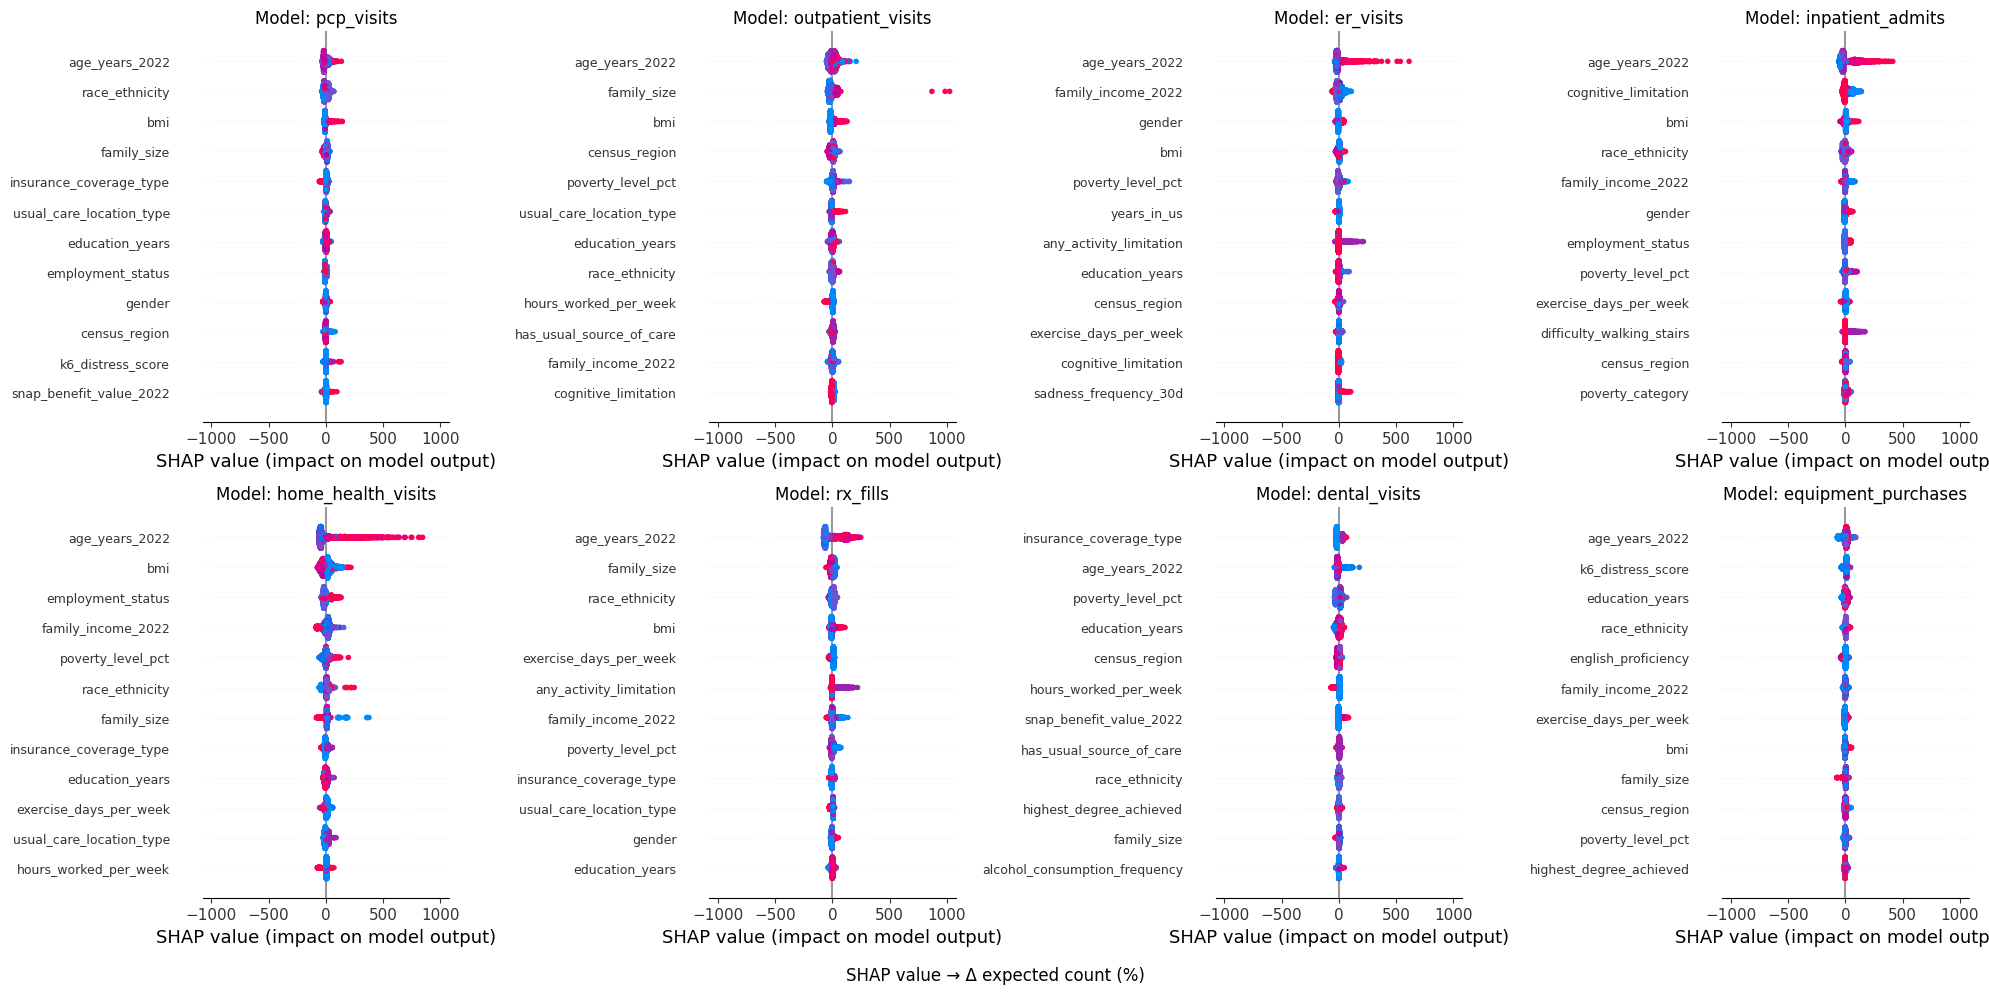

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib
from collections import defaultdict

# -------------------- CONFIG --------------------
TOP_K = 12            # beeswarms are more informative with >5
SCALE = "pct"         # "pct" -> percent change in expected count; "log" -> raw log units
BACKGROUND_ERROR = 0.02

# ----------------- HELPERS ----------------------
def parent_feature_name(name: str) -> str:
    """
    Map transformed names back to parent features.
    Adjust if your ColumnTransformer prefixes differ.
    """
    if "__" in name:
        prefix, rest = name.split("__", 1)
        if prefix == "cat":
            return rest.rsplit("_", 1)[0]   # drop trailing _<category>
        else:
            return rest                     # e.g., 'remainder__age' -> 'age'
    return name

def ensure_numeric_codes(col: pd.Series) -> np.ndarray:
    if np.issubdtype(col.dtype, np.number):
        return col.to_numpy()
    return col.astype("category").cat.codes.to_numpy()

def build_grouped(phi, Xt_trans, feat_names, X_raw):
    """
    Group SHAP values and color-values by parent feature.
    Returns parents, phi_grouped, X_color_grouped
    """
    parent_map = defaultdict(list)
    for j, fname in enumerate(feat_names):
        parent_map[parent_feature_name(fname)].append(j)

    parents = list(parent_map.keys())
    # Sum SHAP per parent (keeps sign; valid by local accuracy)
    phi_grouped = np.column_stack([phi[:, idxs].sum(axis=1) for idxs in parent_map.values()])

    # Color values:
    X_color_cols = []
    for p, idxs in parent_map.items():
        if len(idxs) == 1:
            if isinstance(X_raw, pd.DataFrame) and (p in X_raw.columns):
                X_color_cols.append(ensure_numeric_codes(X_raw[p]))
            else:
                X_color_cols.append(Xt_trans[:, idxs[0]])
        else:
            sub = Xt_trans[:, idxs]
            code = sub.argmax(axis=1).astype(float)
            # if all-zero (dropped base), mark as -1
            code[(sub.max(axis=1) <= 0)] = -1.0
            X_color_cols.append(code)

    X_color_grouped = np.column_stack(X_color_cols)
    return parents, phi_grouped, X_color_grouped

def to_display_scale(phi_grouped):
    """Scale SHAP values for display."""
    if SCALE == "pct":
        return np.expm1(phi_grouped) * 100.0   # signed % change in expected count
    return phi_grouped

x_label = "SHAP value → Δ expected count (%)" if SCALE == "pct" else "SHAP value (log-count units)"

# ---------------- pass 1: compute + pack per model ----------------
packed = []     # {"target","phi_disp","X_disp","feat_names"}
global_xlim = 0.0

for TARGET in count_targets:
    pipe   = joblib.load(f"/Users/orenj/Desktop/open-coverage/python-models/models/v2-pkl/model_{TARGET}.pkl")
    model  = pipe.named_steps["model"]
    preproc = pipe.named_steps["preproc"]

    # Background + explainer (transformed space)
    X_background = slovins_sample(X_train, error=BACKGROUND_ERROR)
    Xb_trans = preproc.transform(X_background)
    explainer = shap.TreeExplainer(
        model,
        data=Xb_trans,
        feature_perturbation="interventional"
    )

    # Transform test + SHAP
    Xt_trans = preproc.transform(X_test)
    phi = explainer.shap_values(Xt_trans, check_additivity=False)   # (n_samples, n_transformed_features)
    feat_names = preproc.get_feature_names_out()

    # Group to parent features
    parents, phi_grouped, X_color_grouped = build_grouped(phi, Xt_trans, feat_names, X_test)

    # Rank by mean(|phi|) and take Top-K (ranking done on raw log scale or any monotone transform)
    mean_abs = np.mean(np.abs(phi_grouped), axis=0)
    order = np.argsort(mean_abs)[-TOP_K:][::-1]

    parents_sel = np.array(parents)[order]
    phi_sel     = phi_grouped[:, order]
    Xcolor_sel  = X_color_grouped[:, order]

    # Scale (keep sign for beeswarm)
    phi_disp = to_display_scale(phi_sel)

    global_xlim = max(global_xlim, float(np.nanmax(np.abs(phi_disp))))
    packed.append({
        "target": TARGET,
        "phi_disp": phi_disp,
        "X_disp": Xcolor_sel,
        "feat_names": parents_sel
    })

# ---------------- pass 2: plot ALL beeswarms in ONE FIGURE ----------------
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True)  # grid like your bar chart
axes = axes.flatten()

for ax, item in zip(axes, packed):
    plt.sca(ax)  # make this axes "current" so SHAP draws here
    shap.summary_plot(
        item["phi_disp"],               # grouped + scaled SHAP (signed)
        item["X_disp"],                 # grouped color values (numeric codes)
        feature_names=item["feat_names"],
        max_display=min(TOP_K, item["phi_disp"].shape[1]),
        show=False,
        color_bar=False,                # avoid 8 colorbars
        plot_size=None                  # don't let SHAP resize the figure
    )
    ax.set_title(f"Model: {item['target']}")
    ax.set_xlim(-global_xlim * 1.05, global_xlim * 1.05)
    # optional: smaller tick label size
    ax.tick_params(axis='y', labelsize=9)

# common x-label
try:
    fig.supxlabel(x_label)
except Exception:
    for ax in axes[-4:]:
        ax.set_xlabel(x_label)

plt.tight_layout()
plt.show()


While the one-hot dummy was included in these it is okay to just include the whole variable for now.

18 Most Important features:

| Category                   | Final variable name            | Plain-English feature                |
| -------------------------- | ------------------------------ | ------------------------------------ |
| **Demographics**           | `age_years_2022`               | Age                                  |
|                            | `gender`                       | Sex                                  |
|                            | `race_ethnicity`               | Race / Ethnicity                     |
|                            | `census_region`                | Census Region                        |
| **Socioeconomic**          | `education_years`              | Years of Schooling                   |
|                            | `family_size`                  | Family Size                          |
|                            | `family_income_2022`           | Family Income (2022 \$)              |
|                            | `poverty_level_pct`            | Poverty Level (% FPL)                |
|                            | `occupation_industry_category` | Industry Category                    |
|                            | `employment_status`            | Employment Status                    |
| **Access & Utilization**   | `usual_care_location_type`     | Location of Usual Care               |
|                            | `has_usual_source_of_care`     | Has a Usual Source of Care           |
|                            | `insurance_coverage_type`      | Insurance Status                     |
| **Behaviors & Lifestyle**  | `english_proficiency`          | English-speaking Ability             |
|                            | `bmi`                          | Body-Mass Index                      |
| **Functional & Cognitive** | `difficulty_walking_stairs`    | Difficulty Walking / Climbing Stairs |
|                            | `any_activity_limitation`      | Any Activity Limitation              |
|                            | `k6_distress_score`            | Psychological Distress (K-6)         |


## Baseline Analysis

In [28]:
# Define realistic synthetic data for one individual
baseline_user = {
    # Identifiers
    "person_id": 99999999,

    # Important 
    "age_years_2022": 80,               
    "gender": 1,                            # Male
    "race_ethnicity": 1,                    # Hispanic
    "family_size": 3,
    "family_income_2022": 32000,
    "employment_status": 1,                 # Unemployed
    "bmi": 18.5,                            # Obese
    "difficulty_walking_stairs": 2,         # No difficulty walking
    "any_activity_limitation": 1,           # Yes, limited activities
    "k6_distress_score": 4,                 # Moderate psychological distress

    # Socioeconomic
    "education_years": np.nan,
    "highest_degree_achieved": np.nan,    # High school graduate
    "poverty_level_pct": np.nan,        # 140% of FPL
    "poverty_category": np.nan,           # 100–199%
    "hours_worked_per_week": np.nan,
    "occupation_industry_category": np.nan,  # Not applicable / unemployed
    "marital_status": np.nan,             # Widowed
    "spouse_in_household": np.nan,        # No spouse in household

    # Access & Utilization
    "insurance_coverage_type": np.nan,          # Public only (e.g., Medicaid)
    "has_usual_source_of_care": np.nan,         # Has usual source of care
    "usual_care_location_type": np.nan,         # Clinic/health center
    "delayed_care_due_to_cost": np.nan,         # Could not afford care
    "delayed_prescription_due_to_cost": np.nan, # Delayed meds due to cost
    "received_snap": np.nan,                    # Received food stamps
    "snap_benefit_value_2022": np.nan,

    # Behaviors & Lifestyle
    "smoking_frequency": np.nan,             # Some days
    "alcohol_consumption_frequency": np.nan, # <4 times/week
    "exercise_days_per_week": np.nan,        # 1 day/week
    "english_proficiency": np.nan,           # Very well
    "us_born_flag": np.nan,                  # Born in US
    "years_in_us": np.nan,                  # N/A (born in US)
    #"metro_status": np.nan,                  # N/A (born in US)

    # Functional & Cognitive
    "difficulty_lifting_carrying": np.nan,       # Yes, difficulty lifting
    "cognitive_limitation": np.nan,              # No cognitive limitations
    "hopelessness_frequency_30d": np.nan,        # Some of the time
    "sadness_frequency_30d": np.nan,             # Some of the time

    # Health Status
    #"chronic_condition_count": np.nan,        # Has multiple chronic conditions; CHANGE IN LATER MODEL VERSION

    # Outcome (for training)
    "total_expenditures_2022": 18934.65     # Total expenditures in 2022 (USD)
}

# Create DataFrame with the synthetic individual
baseline_df = pd.DataFrame([baseline_user])

# Make predictions using the trained models
predictions = {}
for target in count_targets:
    # Use the trained model to predict
    pred_value = models[target].predict(baseline_df)[0]
    predictions[target] = max(0, round(pred_value))  # Ensure non-negative integers

# Create predictions DataFrame
predictions_df = pd.DataFrame([predictions])

print("Predicted Healthcare Utilization Counts:")
display(predictions_df)

Predicted Healthcare Utilization Counts:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:2

,pcp_visits,outpatient_visits,er_visits,inpatient_admits,home_health_visits,rx_fills,dental_visits,equipment_purchases
0,2,0,0,1,0,1,0,0
